<a href="https://colab.research.google.com/github/igormatheusdiniz/ri_lab_06/blob/master/ri_lab6_igor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import heapq as hp
import math

import nltk
nltk.download('rslp')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import heapq as hp


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
url = 'https://raw.githubusercontent.com/Benardi/ri_lab_01/master/output/results.csv'

Utilizei a base de dados de Benardi, e por motivos de não precisar importar o .csv toda vez ao inicializar o colab, defini a url em meu lab.

# Tratamento dos dados

In [0]:
dataframe = pd.read_csv(url)
dataframe['treatedText'] = dataframe.text.apply(lambda x: re.sub('[^0-9A-ZÀ-Úa-zà-ú\']', ' ', x.lower()))

Diferente do lab anterior onde para obter os tokens, não utilizei o método tokenize do ntlk, para atender as especificações do lab atual, atualizei a forma que recupero os tokens do meu texto.

In [0]:
regex = RegexpTokenizer(r'[A-zÀ-ú-]+')
stopWords = set(stopwords.words('portuguese'))

# Questão 1 e 2

## Algoritimo de construção de índice Invertido

In [0]:

def ocurrences(list, token):
  print(list)
  print(token)
  count = 0
  for word in list:
    if word==token:
      count +=1
  return count
      

def invertedIndex(documents):
  I = {}
  index = 0
  
  ##Para cada documento na minha relação de documentos irei realizar o processo de tokenização
  for document in documents.treatedText:
    index += 1
    T = [token for token in regex.tokenize(document)
        if((len(token)>=3) and token not in stopWords and token[0] != "[" and token[-1]!="]")]
    
    ##Por motivos didáticos, resolvi ordenar minha lista de tokens
    #T.sort()
    
    ## Pra cada token criado se ele ainda não existe na minha estrutura de armazenamento como uma chave, eu crio e em seguida adiciono
    ##o indice do documento como valor para esta chave
    ## Caso já exista, apenas adiciona o índice do documento para esta chave
    for token in T:
      if token not in I.keys():
        I[token]=[]
       
      pair = []
      ocurrence = T.count(token)
     
      pair.append(index)
      pair.append(ocurrence)
      if(pair not in I[token]):
        I[token].append(pair)
  
  ## Calculo do IDF
  for key in I:
    idf = math.log((documents.treatedText.count()+1)/ len(I[key]))
    I[key].append(idf)
        
  ## Por motivos estéticos resolvi comentar esta linha para não ficar uma lista de print muito grande no gitHub, dificultando a visualização do documento como um todo      
  ##print(I)
  return I

## Exportando para .csv
invertedIndex = invertedIndex(dataframe)
data = {'token': list(invertedIndex.keys()), 'ocurrences': list(invertedIndex.values())}
df = pd.DataFrame(data)
df.to_csv('index.csv')

# Questão 3

## Modelo Binario

In [77]:
def binarioModelDocument(document):
  vetores = []
  #for document in dataframe.treatedText:
  ## Tokenização do documento passado
  dicionario = {}
  T = [token for token in regex.tokenize(document)
      if((len(token)>=3) and token not in stopWords and token[0] != "[" and token[-1]!="]")]
    
    ##Por motivos didáticos, resolvi ordenar minha lista de tokens
  #T.sort()
  
  for indice in invertedIndex:
    dicionario[indice] = 0
    
    if indice in T :
      dicionario[indice] = 1

  return dicionario

## Metodo para calculo do Score
def calculaScore(vetorQuery, vetorDocument):
  ##Criação de dois vetores com relação ao vocabulario, query vs. vocabulario, document vs. vocabulario
  vetor_num_query = np.array(list(vetorQuery.values()))
  vetor_num_documents = np.array(list(vetorDocument.values()))
  ##Multiplicação dos vetores
  result = vetor_num_query * vetor_num_documents
  result = sum(result)
  return result


def binarioModel(consulta, document): 
  dicionario = {}
  scores = []
  vetor = binarioModelDocument(document)
  
  for indice in invertedIndex:
    dicionario[indice] = 0
    
    if indice in consulta.split() :
      dicionario[indice] = 1
  
  ## Calculo do score por modelo Binario, chamando o método auxiliar criado anteriormente
  score = calculaScore(dicionario, vetor)       
  return (score)

binary_model = binarioModel("juíza federal",dataframe.treatedText[0])
print(binary_model)
  
    

2


##  TF

In [78]:
def termFrequency(terms, document):
  hashtable = {}
  query =[]
  document_vocabulary = []
  
  ## Tokenização do documento
  document_vocabulary = [token for token in regex.tokenize(document)
      if((len(token)>=3) and token not in stopWords and token[0] != "[" and token[-1]!="]")]
  
  ## Construção do vetor de termos em comum da query e do vocabulario
  for term in terms.split():
    if term in invertedIndex.keys():
      query.append(term)
    
  ## Contagem da frequência de acordo o palavra no vocabulario e na query de consulta  
  frequency = 0
  for word in document_vocabulary:
    if word in query:
      frequency += 1
    
  return (frequency)

resultado = termFrequency("juíza federal", dataframe.treatedText[158])

print(resultado)

0


## TF - IDF

In [79]:
def tf_idf(terms, document):
  hashtable = {}
  invertedLists ={}
  R = []
  
  document_vocabulary = [token for token in regex.tokenize(document)
                         if((len(token)>=3) and token not in stopWords and token[0] != "[" and token[-1]!="]")]
  
  for term in terms.split():
    if term in invertedIndex.keys():
      invertedLists[term] = []
      invertedLists[term] = invertedIndex[term]
  
  ## Semelhante ao metodo
  frequency = 0
  for word in document_vocabulary:
    if word in invertedLists:
      frequency += 1*invertedLists[word][-1]
  
  return frequency

resultado = tf_idf("juíza federal", dataframe.treatedText[14])

print(resultado)

1.6296406197516198


## BM25

In [80]:
N = dataframe.text.count()
def bm25(consulta, document, k):
  document_vocabulary = [token for token in regex.tokenize(document)
                         if((len(token)>=3) and token not in stopWords and token[0] != "[" and token[-1]!="]")]
  query = consulta.split()
  intersec =  list(set(document_vocabulary) & set(query))
  
  score = 0
  for word in intersec:
    cwq = query.count(word)
    cwd = document_vocabulary.count(word)
    dfw = len(invertedIndex[word][:-1])
    y = ((k+1)*cwd)/(cwd+k)
    score += cwq*y*math.log((N+1)/(dfw))
  
  return score
    
bm25_result = bm25('forças armadas', dataframe.treatedText[149], 5)
print(bm25_result)
  

16.073889420086477


### Testando para vários Ks

In [0]:
consultas = ["forças armadas", "jair bolsonaro", "universidades federais"]

In [82]:
k_num = []
resultados = []

## Simulando o algoritimo BM25 para diferentes valores de K
for consulta in consultas:
  for k in [0, 1, 10, 15, 20, 100, 150, 200, 500, 1000,1500,2000,2500,5000,10000]:
    result = bm25(consulta, dataframe.treatedText[149], k)
    resultados.append(result)
    k_num.append(k)
    print("=================")
    print("Consulta: %s - k: %d" % (consulta, k))
    print("resultado:  %f" % (result))
  
tible = pd.DataFrame()
tible["k"] = k_num
tible["resultados"] = resultados
tible = tible[0:15]
tible

Consulta: forças armadas - k: 0
resultado:  4.487565
Consulta: forças armadas - k: 1
resultado:  7.906309
Consulta: forças armadas - k: 10
resultado:  21.012826
Consulta: forças armadas - k: 15
resultado:  23.751972
Consulta: forças armadas - k: 20
resultado:  25.493711
Consulta: forças armadas - k: 100
resultado:  31.321304
Consulta: forças armadas - k: 150
resultado:  31.956949
Consulta: forças armadas - k: 200
resultado:  32.286247
Consulta: forças armadas - k: 500
resultado:  32.899405
Consulta: forças armadas - k: 1000
resultado:  33.109874
Consulta: forças armadas - k: 1500
resultado:  33.180728
Consulta: forças armadas - k: 2000
resultado:  33.216287
Consulta: forças armadas - k: 2500
resultado:  33.237665
Consulta: forças armadas - k: 5000
resultado:  33.280517
Consulta: forças armadas - k: 10000
resultado:  33.301991
Consulta: jair bolsonaro - k: 0
resultado:  0.000000
Consulta: jair bolsonaro - k: 1
resultado:  0.000000
Consulta: jair bolsonaro - k: 10
resultado:  0.000000
Co

,k,resultados
0,0,4.487565
1,1,7.906309
2,10,21.012826
3,15,23.751972
4,20,25.493711
5,100,31.321304
6,150,31.956949
7,200,32.286247
8,500,32.899405
9,1000,33.109874


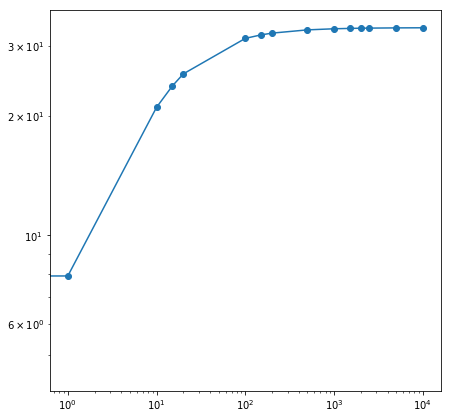

In [83]:
%matplotlib inline

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
plt.plot(tible["k"], 
         tible["resultados"],
         linestyle='-',
         marker='o')

### Discussão para a escolha do K

Podemos perceber que para valores muito baixos o valor de K não é bom, e para valores muito altos o resultado se assemelha a um resultado intermediário. Para o caso em questão a partir do K=5 os valores do resultado são muito próximos. Logo um valor intermediário seria a melhor escolha.

# Questão 4

In [0]:
def calculeModels(consulta, dataframe):
  table1 = pd.DataFrame()

  rank_binario = []
  rank_termFrequency = []
  rank_tf_idf = []
  rank_bm25 = []

  document_number = 1
  for document in dataframe.treatedText:
  
    score_binario = binarioModel(consulta, document)
    score_termFrequency = termFrequency(consulta, document)
    score_tf_idf = tf_idf(consulta, document)
    score_bm25 = bm25(consulta, document,10)
  
    rank_binario.append((document_number, score_binario))
    rank_termFrequency.append((document_number, score_termFrequency))
    rank_tf_idf.append((document_number, score_tf_idf))
    rank_bm25.append((document_number, score_bm25))
  
    document_number+=1

  rank_binario.sort(key=lambda x: x[1], reverse = True)
  rank_termFrequency.sort(key=lambda x: x[1], reverse = True)
  rank_tf_idf.sort(key=lambda x: x[1], reverse = True)
  rank_bm25.sort(key=lambda x: x[1], reverse = True)

  table1["Binario"] = rank_binario
  table1["TF"] = rank_termFrequency
  table1["Tf-Idf"] = rank_tf_idf
  table1["BM25"] = rank_bm25

  return table1

In [0]:
def createTable(consulta, dataframe):
  table1 = pd.DataFrame()

  rank_binario = []
  rank_termFrequency = []
  rank_tf_idf = []
  rank_bm25 = []

  document_number = 0
  for document in dataframe.treatedText:
  
    score_binario = binarioModel(consulta, document)
    score_termFrequency = termFrequency(consulta, document)
    score_tf_idf = tf_idf(consulta, document)
    score_bm25 = bm25(consulta, document,10)
  
    rank_binario.append((document_number, score_binario))
    rank_termFrequency.append((document_number, score_termFrequency))
    rank_tf_idf.append((document_number, score_tf_idf))
    rank_bm25.append((document_number, score_bm25))
  
    document_number+=1

  rank_binario.sort(key=lambda x: x[1], reverse = True)
  rank_termFrequency.sort(key=lambda x: x[1], reverse = True)
  rank_tf_idf.sort(key=lambda x: x[1], reverse = True)
  rank_bm25.sort(key=lambda x: x[1], reverse = True)

  rank_binario = rank_binario[0:5]
  rank_termFrequency = rank_termFrequency[0:5]
  rank_tf_idf = rank_tf_idf[0:5]
  rank_bm25 = rank_bm25[0:5]

  table1["Binario"] = rank_binario
  table1["TF"] = rank_termFrequency
  table1["Tf-Idf"] = rank_tf_idf
  table1["BM25"] = rank_bm25

  return table1

## Consulta: presidente jair

In [86]:
tableJair = createTable("presidente jair", dataframe)
tableJair

,Binario,TF,Tf-Idf,BM25
0,"(0, 2)","(62, 21)","(206, 36.60740036104147)","(206, 18.46287284547201)"
1,"(1, 2)","(150, 18)","(150, 24.7804771061628)","(150, 15.289388234114178)"
2,"(24, 2)","(165, 18)","(165, 17.578504509375556)","(165, 9.981042796012439)"
3,"(85, 2)","(206, 17)","(62, 16.307104579478928)","(215, 7.051306868666213)"
4,"(150, 2)","(215, 12)","(215, 11.118838623184768)","(85, 6.6231456313484705)"


## Consulta: universidade federal

In [87]:
createTable("universidade federal", dataframe)

,Binario,TF,Tf-Idf,BM25
0,"(2, 2)","(129, 16)","(129, 32.39925370233226)","(129, 13.707376566371341)"
1,"(6, 2)","(215, 13)","(215, 26.32439363314496)","(215, 12.589927389764982)"
2,"(164, 2)","(172, 9)","(172, 16.64332926098531)","(172, 12.546556635527661)"
3,"(172, 2)","(213, 7)","(213, 12.988735284837924)","(213, 10.50091915485509)"
4,"(202, 2)","(150, 5)","(150, 8.1482030987581)","(209, 6.769906832140872)"


## Consulta: festas universitárias

In [88]:
createTable("escola infantil", dataframe)

,Binario,TF,Tf-Idf,BM25
0,"(202, 2)","(238, 9)","(238, 18.787263420393902)","(202, 12.535073640744613)"
1,"(5, 1)","(202, 5)","(202, 15.384419075481208)","(238, 10.876836717070153)"
2,"(6, 1)","(213, 5)","(213, 10.437368566885501)","(213, 7.6540702823827)"
3,"(10, 1)","(79, 4)","(79, 8.3498948535084)","(79, 6.560631670613743)"
4,"(28, 1)","(5, 2)","(30, 6.648472681052054)","(30, 6.094433290964383)"


# Questão 5

## Quais modelos você acha que trouxe os melhores resultados? Por que? Inspecione os documentos retornados para melhor embasar sua resposta.

Levando em consideração a consulta "presidente jair"



In [89]:
table_docs = tableJair.applymap(lambda x: x[0])
table_docs

,Binario,TF,Tf-Idf,BM25
0,0,62,206,206
1,1,150,150,150
2,24,165,165,165
3,85,206,62,215
4,150,215,215,85


In [90]:
pd.options.display.max_colwidth = 500

for model in table_docs:
  docs = table_docs[model]
  df = dataframe[['title','subtitle']].iloc[docs]
  print(f'{model}')
  display(df)
  print('\n')

Binario


,title,subtitle
0,“A sociedade foi Rubens Paiva não os facínoras que o mataram”,A decisão da juíza que proíbe as Forças Armadas de celebrarem golpe de 1964 contrapõe texto de militares ao de Ulysses Guimarães na Constituinte. Gilmar Mendes rejeita análise do tema
1,Justiça suspende decisão que proibia Forças Armadas de celebrarem golpe de 1964,Liminar havia sido concedida na sexta-feira a noite mas menos de 24 horas depois foi derrubada
24,Boris Fausto e o golpe de 64: “É impossível ir contra fatos estabelecidos”,Historiador diz que as Forças Armadas nunca reconheceram os aspectos mais negativos do regime militar e que não havia ameaça imediata de implantação de um regime comunista
85,Presidente na ficção humorista é favorito em disputa eleitoral na Ucrânia,Admirador declarado de Bolsonaro o ator Volodymyr Zelenskiy lidera as pesquisas para as eleições deste domingo explorando a insatisfação popular com a elite política
150,Quem mandou matar Marielle? E por quê?,Bolsonaro que governa o Brasil pela administração do ódio deveria ser o maior interessado em desvendar o crime




TF


,title,subtitle
62,“Chamar-me de traidor foi uma estratégia muito bem montada para minar minha liderança”,Ex-presidente conversa sobre seu livro ‘La Batalla por la Paz’ um relato repleto de detalhes casos e confidências sobre as negociações com as FARC
150,Quem mandou matar Marielle? E por quê?,Bolsonaro que governa o Brasil pela administração do ódio deveria ser o maior interessado em desvendar o crime
165,Bolsonaro manda festejar o crime,Ao determinar a comemoração do golpe militar de 1964 o antipresidente busca manter o ódio ativo e barrar qualquer possibilidade de justiça
206,Dois assessores de Bolsonaro doaram mais de 100.000 reais a campanhas da família,Levantamento da Pública mostra que outros cinco assessores prestaram serviços de campanha enquanto estavam contratados pelo atual presidente ou seus três filhos
215,Um Brasil de dedo em riste às portas do Mackenzie,A expectativa de uma visita do presidente Jair Bolsonaro à universidade em São Paulo cenário emblemático da luta estudantil durante a ditadura gerou embates inflamados entre estudantes e bolsonaristas




Tf-Idf


,title,subtitle
206,Dois assessores de Bolsonaro doaram mais de 100.000 reais a campanhas da família,Levantamento da Pública mostra que outros cinco assessores prestaram serviços de campanha enquanto estavam contratados pelo atual presidente ou seus três filhos
150,Quem mandou matar Marielle? E por quê?,Bolsonaro que governa o Brasil pela administração do ódio deveria ser o maior interessado em desvendar o crime
165,Bolsonaro manda festejar o crime,Ao determinar a comemoração do golpe militar de 1964 o antipresidente busca manter o ódio ativo e barrar qualquer possibilidade de justiça
62,“Chamar-me de traidor foi uma estratégia muito bem montada para minar minha liderança”,Ex-presidente conversa sobre seu livro ‘La Batalla por la Paz’ um relato repleto de detalhes casos e confidências sobre as negociações com as FARC
215,Um Brasil de dedo em riste às portas do Mackenzie,A expectativa de uma visita do presidente Jair Bolsonaro à universidade em São Paulo cenário emblemático da luta estudantil durante a ditadura gerou embates inflamados entre estudantes e bolsonaristas




BM25


,title,subtitle
206,Dois assessores de Bolsonaro doaram mais de 100.000 reais a campanhas da família,Levantamento da Pública mostra que outros cinco assessores prestaram serviços de campanha enquanto estavam contratados pelo atual presidente ou seus três filhos
150,Quem mandou matar Marielle? E por quê?,Bolsonaro que governa o Brasil pela administração do ódio deveria ser o maior interessado em desvendar o crime
165,Bolsonaro manda festejar o crime,Ao determinar a comemoração do golpe militar de 1964 o antipresidente busca manter o ódio ativo e barrar qualquer possibilidade de justiça
215,Um Brasil de dedo em riste às portas do Mackenzie,A expectativa de uma visita do presidente Jair Bolsonaro à universidade em São Paulo cenário emblemático da luta estudantil durante a ditadura gerou embates inflamados entre estudantes e bolsonaristas
85,Presidente na ficção humorista é favorito em disputa eleitoral na Ucrânia,Admirador declarado de Bolsonaro o ator Volodymyr Zelenskiy lidera as pesquisas para as eleições deste domingo explorando a insatisfação popular com a elite política


Acima temos os títulos de cada documento que apareceu como melhor resultado para a consulta, bem como o subtitulo. Nesses testes podemos perceber que o TF-IDF e o BM25 tem o melhor desempenho visto que o conteúdo do titulo e subtitulo já deixam bem claro de cara que o conteudo do texto tem relação com os termos pesquisados.

##  Calcule e reporte o overlap par-a-par entre os resultados de cada modelo

In [91]:
tible2 = createTable("presidente jair", dataframe)
result_binario = tible2["Binario"]
result_tf =tible2["TF"]
result_tf_idf = tible2["Tf-Idf"]
result_bm25 = tible2["BM25"]

tible2

,Binario,TF,Tf-Idf,BM25
0,"(0, 2)","(62, 21)","(206, 36.60740036104147)","(206, 18.46287284547201)"
1,"(1, 2)","(150, 18)","(150, 24.7804771061628)","(150, 15.289388234114178)"
2,"(24, 2)","(165, 18)","(165, 17.578504509375556)","(165, 9.981042796012439)"
3,"(85, 2)","(206, 17)","(62, 16.307104579478928)","(215, 7.051306868666213)"
4,"(150, 2)","(215, 12)","(215, 11.118838623184768)","(85, 6.6231456313484705)"


In [0]:
consultas = ["presidente jair", "universidade federal", "escola infantil"]
jaccard_binario_tf = []
jaccard_binario_tf_idf = []
jaccard_binario_bm25 = []
jaccard_tf_tf_idf = []
jaccard_tf_bm25 = []
jaccard_tf_idf_bm25 = []

In [0]:
def jaccard(result1, result2):
  aux1 = []
  aux2 = []
  
  for item in result1:
    if(item[1] != 0):
      aux1.append(item[0])
      
  for item2 in result2:
    if(item2[1] != 0):
      aux2.append(item2[0])
  
  aeb = len(set(aux1) & set(aux2))
  
  a = len(aux1)
  b = len(aux2)  
  jaccard = aeb / (a + b - aeb)
  
  return jaccard

#binarioTf = jaccard(result_binario,result_bm25)
#print(binarioTf)

In [0]:
for consulta in consultas:
  
  ## Estrutura para criação da tabela com os valores dos Indices de Jaccard
  tible2 = createTable(consulta, dataframe)
  result_binario = tible2["Binario"]
  result_tf =tible2["TF"]
  result_tf_idf = tible2["Tf-Idf"]
  result_bm25 = tible2["BM25"]
  
  binarioTf = jaccard(result_binario,result_tf)
  jaccard_binario_tf.append(binarioTf)
  
  binarioTf_idf = jaccard(result_binario,result_tf_idf)
  jaccard_binario_tf_idf.append(binarioTf_idf)
  
  binario_bm25 = jaccard(result_binario,result_bm25)
  jaccard_binario_bm25.append(binario_bm25)
 
  tf_tf_idf = jaccard(result_tf, result_tf_idf)
  jaccard_tf_tf_idf.append(tf_tf_idf)
 
  tf_bm25 = jaccard(result_tf, result_bm25)
  jaccard_tf_bm25.append(tf_bm25)
 
  tf_idf_bm25 = jaccard(result_tf_idf, result_bm25)
  jaccard_tf_idf_bm25.append(tf_idf_bm25)

### Tabela: Índice de Jaccard (par-a-par)

In [95]:
tabela5 = pd.DataFrame()

tabela5["Consultas"] = consultas
tabela5["binario_tf"] = jaccard_binario_tf
tabela5["binario_tf_idf"] = jaccard_binario_tf_idf
tabela5["binario_bm25"] = jaccard_binario_bm25
tabela5["tf_tf_idf"] = jaccard_tf_tf_idf
tabela5["tf_bm25"] = jaccard_tf_bm25
tabela5["tf_idf_bm25"] = jaccard_tf_idf_bm25

tabela5

,Consultas,binario_tf,binario_tf_idf,binario_bm25,tf_tf_idf,tf_bm25,tf_idf_bm25
0,presidente jair,0.111111,0.111111,0.250000,1.000000,0.666667,0.666667
1,universidade federal,0.111111,0.111111,0.111111,1.000000,0.666667,0.666667
2,escola infantil,0.250000,0.111111,0.111111,0.666667,0.666667,1.000000
